In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.nn import Sigmoid

from torch import transpose
from sklearn.neural_network import BernoulliRBM
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

In [29]:
from helpers import *
#from nmf_utils import *
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!ffmpeg -i  "/content/drive/MyDrive/vocal_10.mp3" "vocal.wav"
!ffmpeg -i  "/content/drive/MyDrive/piano_10.mp3" "music.wav"

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [71]:
def load_data(path_music,path_speech,sec):

  samplerate_m,music = read(path_music)
  music=music[:44100*sec,0]
  length=music.shape[0]/samplerate_m
  print('Shape of the music {}'.format(music.shape[0]))
  print('Length : {:.2f}s'.format(length))
  print('Sample rate : {}'.format(samplerate_m))


  samplerate_s,speech = read(path_speech)
  speech=speech[:44100*sec,0]

  length=speech.shape[0]/samplerate_s
  print('Shape of the speech {}'.format(speech.shape[0]))
  print('Length : {:.2f}s'.format(length))
  print('Sample rate : {}'.format(samplerate_s))

  return music,speech,samplerate_s


In [72]:
path_music  = "music.wav"
path_speech = "vocal.wav"
sec = 1088
music,speech_t,samplerate = load_data(path_music,path_speech,sec)

Shape of the music 47980800
Length : 1088.00s
Sample rate : 44100
Shape of the speech 47980800
Length : 1088.00s
Sample rate : 44100


## Low band Filter

In [46]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

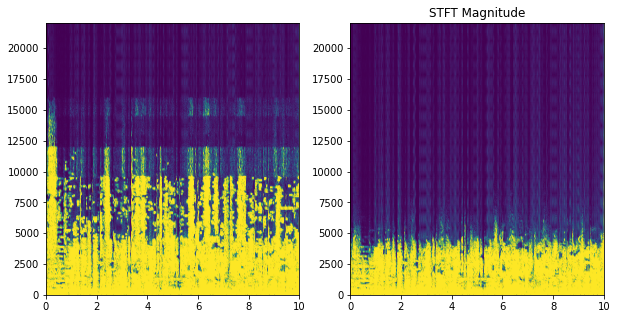

In [37]:
def Viz_Y(t,f,Y,Y_filtered, vmin=0, vmax=20):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.pcolormesh(t, f, Y,vmin=0, vmax=20, shading='gouraud')
    ax2.pcolormesh(t, f, Y_filtered,vmin=0, vmax=20, shading='gouraud')

    plt.title('STFT Magnitude')
    #ax.ylabel('Frequency [Hz]')
    #ax.xlabel('Time [sec]')
    plt.show()

  
speech_filtered = butter_lowpass_filter(speech,3000,44100)
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512

f,t,M= signal.stft(speech[44100*10:44100*20],44100,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal
f,t,M_1= signal.stft(speech_filtered[44100*10:44100*20],44100,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal

Viz_Y(t,f,np.abs(M),np.abs(M_1), vmin=0, vmax=20)


In [39]:
 _, aa =  signal.istft( M_1,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
write("test.wav", samplerate, aa.astype(np.int16))


## Resampling

In [47]:
from scipy import signal

In [61]:
rate = 44100/16000
speech_t = signal.resample(speech_t,int(speech_t.shape[0]/rate))
music=signal.resample(music,int(music.shape[0]/rate))
samplerate_m=int(samplerate/rate)
samplerate_s=samplerate_m
samplerate_t=samplerate_m

In [62]:
samplerate_t

16000

# NMF

In [65]:
#from helpers import *

def speech_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G, model.reconstruction_err_
def music_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G, model.reconstruction_err_




In [66]:
def Reconstruct(B,G,Ns,Nm,Yabs,p):
    
    numerators=[]
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerators.append(np.power(np.matmul(B1,G1),p))
    numerators.append(np.power(np.matmul(B2,G2),p))

    denominator = np.power(np.matmul(B1,G1),p)+np.power(np.matmul(B2,G2),p)
  
    

    Sources=[]
    Masks=[]
    for i in range(2):

        Sources.append(np.multiply(numerators[i]/denominator,Yabs))
        Masks.append(numerators[i]/denominator)

    #print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources,Masks
def training(music_s,
               speech_s,
                          init,

               s_component = 128,
               m_component = 128,
               iterations = 200,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
             samplerate=samplerate_t,
                ):
  ###################################   STFT   #######################################
  WINDOW = 'hamming'
  WINDOW_SIZE=480
  OVERLAP = 0.6 * WINDOW_SIZE
  NFFT=512
  #_,speech_s,music_s = get_mixed_signal(spe)

  f,t,M= signal.stft(music_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal

  f,t,S= signal.stft(speech_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)   # spectrum  of speech signal

  #####################################################################################


  ## Magnitude of each spectrum source 

  M_abs=np.abs(M)

  S_abs=np.abs(S)




  ##############################   NMF Training   #####################################
  print("Training Stage ....")
  B_speech,_,error_speech = speech_nmf(S_abs,s_component,iterations,s_alpha,initt=init)
  B_music,_,error_music =   music_nmf(M_abs,m_component,iterations,m_alpha,initt=init)
  print("Training finish ! ....")

  #####################################################################################

  B_mixed = np.concatenate([B_speech,B_music],axis = 1)                                # Concatenation of both  training dictionnaries
  print("SPEECH reconstruction Loss {}".format(error_speech))
  print("MUSIC reconstruction Loss {}".format(error_music))

  return B_mixed

In [67]:
def mixed_nmf(B_mixed,
              Y_test,
              iterations,
              a,
              initt,
              ):
  n_components=B_mixed.shape[1]
  model = NMF(n_components=n_components,
              init=initt,
              alpha=a,
              beta_loss='itakura-saito',
              solver="mu",
              max_iter=iterations,
              random_state=0)
  
  model.fit(np.transpose(Y_test))

  model.components_ = np.transpose(B_mixed)

  G0 = model.transform(np.transpose(Y_test))

  return np.transpose(G0),model.reconstruction_err_,model.components_

In [68]:
def validation(B_mixed,
               speech,
               music,
               s_component,
               m_component,
               alpha,
               init,
               smr,
               iterations,
               samplerate=samplerate_t
               ):

  mixed_signal , speech_signal, music_signal = get_mixed_signal(speech,music,smr)
  #mixed_signal = mixed_signal
  WINDOW = 'hamming'
  WINDOW_SIZE=480
  OVERLAP = 0.6 * WINDOW_SIZE
  NFFT=512

  f,t,mixed_spectrum = signal.stft(mixed_signal,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT) # spectrum  of mixed signal

  mixed_abs = np.abs(mixed_spectrum)
  G_mixed,reconstruction,update_or_not = mixed_nmf(B_mixed,
              mixed_abs,
              iterations,
              alpha,
              init
              )
  #B_mixed,G_mixed,error_speech = speech_nmf(mixed_abs,s_component,iterations,0)
  print("ok")
  sources,masks = Reconstruct(B_mixed,
                              G_mixed,
                              s_component,
                              m_component,
                              mixed_spectrum,
                              2)
  _, speech_estimate =  signal.istft( sources[0],samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
  _, music_estimate =    signal.istft(sources[1],samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
  print("Separation finish ! ....")
  #print(speech_estimate.shape, speech.shape)
  sdr_speech = SDR(speech_estimate[:speech_signal.shape[0]],speech_signal)
  
  sdr_music = SDR(music_estimate[:music_signal.shape[0]],music_signal)
  print("Evaluation .....")
  #print(update_or_not)
  print("SMR ={} N_components ={}: \nSDR Speech = {}\nSDR Music  = {}".format(smr,s_component,sdr_speech,sdr_music))
  print(reconstruction)

  write("Speech{}.wav".format(iterations), samplerate, speech_estimate.astype(np.int16))
  write("Music.wav".format(iterations), samplerate, music_estimate.astype(np.int16))
  return smr,sdr_speech,sdr_music,update_or_not

# Train / Validation

In [95]:
speech = butter_lowpass_filter(speech_t,4000,44100)

train_speech   = np.hstack((speech[samplerate_t*60:samplerate_t*440] ,speech[samplerate_t*723:samplerate_t*930]))
train_music    = np.hstack((music[samplerate_t*60:samplerate_t*440] ,  music[samplerate_t*723:samplerate_t*930]))

test_speech ,test_music =  speech[samplerate_t*580:samplerate_t*610]  , music[samplerate_t*580:samplerate_t*610]

In [98]:
B_all_list= []
for c in [5,6,7,8,9,10]:
  B_mixed = training(train_music,
               train_speech,
               s_component = c,
               m_component = c,
               iterations = 100,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
               init="random")
  B_mixed_new = MinMaxScaler().fit_transform(B_mixed)
  B_all_list.append(B_mixed_new)

Training Stage ....
Training finish ! ....
SPEECH reconstruction Loss 1820.3780790402843
MUSIC reconstruction Loss 1773.8311481854205
Training Stage ....
Training finish ! ....
SPEECH reconstruction Loss 1745.154900294013
MUSIC reconstruction Loss 1757.0276195905121
Training Stage ....
Training finish ! ....
SPEECH reconstruction Loss 1739.0961728922814
MUSIC reconstruction Loss 1727.3096074607045
Training Stage ....
Training finish ! ....
SPEECH reconstruction Loss 1701.1182139152952
MUSIC reconstruction Loss 1725.0379463495226
Training Stage ....
Training finish ! ....
SPEECH reconstruction Loss 1663.7080681689126
MUSIC reconstruction Loss 1706.1768964651503
Training Stage ....
Training finish ! ....
SPEECH reconstruction Loss 1652.534715848725
MUSIC reconstruction Loss 1691.5465353014658


In [109]:
my_dict_2= {}
info_dict_2 = {}  
for s in [-5,0,5]:
  smr,sdr_speech,sdr_music,_ = validation(B_all_list[3],test_speech, ## n component = 8 +8
                  test_music,
                  smr=s,
                  iterations=100,
                  m_component=8,
                  s_component=8,
                  alpha=0,
                  init="random"
)
  
  my_dict_2["SMR = {} n_component = {}".format(smr,Q)] = info_dict_2 = ["SDR Speech = {:.2f} SDR Music = {:.2f}".format(sdr_speech,sdr_music)]


SMR = -5.00
ok
Separation finish ! ....
Evaluation .....
SMR =-5 N_components =8: 
SDR Speech = 0.9650085164256379
SDR Music  = 5.9650085164256375
341.38205114862825
SMR = 0.00
ok
Separation finish ! ....
Evaluation .....
SMR =0 N_components =8: 
SDR Speech = 2.8832233502627167
SDR Music  = 2.8832233502627123
340.09971254037794
SMR = 5.00
ok
Separation finish ! ....
Evaluation .....
SMR =5 N_components =8: 
SDR Speech = 5.031264003498563
SDR Music  = 0.03126400349857447
331.48501582875997


Best with : 


fc = 4000


8 components for every sources.

init random.

ALpha = 0

100 iterations for train and test.



In [110]:
np.save("b_train",B_all_list[3])